In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# ## Plotly plotting support
# import plotly.plotly as py

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

# Introduction

In this lecture we examine the process of data cleaning and Exploratory Data Analysis (EDA).  Often you will acquire or even be given a collection of data in order to conduct some analysis or answer some questions. The first step in using that data is to ensure that it is in the correct form (cleaned) and that you understand its properties and limitations (EDA).  Often as you explore data through EDA you will identify additional transformations that may be required before the data is ready for analysis.

In this notebook we obtain crime data from the city of Berkeley's public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data. 

# Unboxing the Data

We have downloaded some data from the city of Berkeley's open data repositories and placed them in the data folder.  The first step to understanding the data is learning a bit about the files.

## How big is the data?

I often like to start my analysis by getting a rough estimate of the size of the data.  This will help inform the tools I use and how I view the data.  If it is relatively small I might use a text editor or a spreadsheet to look at the data.  If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

The following command lists (`l`) the files with human (`h`) readable file sizes:

In [2]:
ls -lh data

total 13936
-rw-r--r--@ 1 jegonzal  staff   979K Aug 29 14:41 Berkeley_PD_-_Calls_for_Service.csv
-rw-r--r--  1 jegonzal  staff    81B Aug 29 14:28 cvdow.csv
-rw-r--r--@ 1 jegonzal  staff   5.8M Aug 29 14:41 stops.json


In some file systems addition attributes describing the file may be available:

In [3]:
ls -lh@ data

total 13936
-rw-r--r--@ 1 jegonzal  staff   979K Aug 29 14:41 Berkeley_PD_-_Calls_for_Service.csv
	com.apple.metadata:kMDItemDownloadedDate	  53B 
	com.apple.metadata:kMDItemWhereFroms	 224B 
	com.apple.quarantine	  61B 
-rw-r--r--  1 jegonzal  staff    81B Aug 29 14:28 cvdow.csv
-rw-r--r--@ 1 jegonzal  staff   5.8M Aug 29 14:41 stops.json
	user.xdg.origin.url	  82B 


You may also want to try the file command:

In [4]:
!file data/*

data/Berkeley_PD_-_Calls_for_Service.csv: ASCII text
data/cvdow.csv:                           ASCII text
data/stops.json:                          UTF-8 Unicode text, with very long lines


This command reveals a bit more about the structure of the data.

All the files are relatively small and we could comfortable examine them in a text editors.  (Personally, I like *sublime* or *emacs* but others may prefer a different *vi*ew.). 

In listing the files I noticed that the names suggest that they are all text file formats:
* **CSV**: Comma separated values is a very standard table format.
* **JSON**: JavaScript Object Notation is a very standard semi-structured file format used to store nested data.

We will dive into the formats in a moment.  However because these are text data I might also want to investigate the number of lines which often correspond to records.

Here I am invoking the shell command via the `!` operator.  The `wc` command computes the number of **lines**, **words**, and **characters** in each file:


In [5]:
!wc data/*

   16497   87732 1002706 data/Berkeley_PD_-_Calls_for_Service.csv
       8       8      81 data/cvdow.csv
   29852  658575 6124111 data/stops.json
   46357  746315 7126898 total


If we wanted to learn more about the command we could use the `man` (short for **manual**) command to read the manual page for `wc` (word count).

In [6]:
man wc

<br/><br/><br/>
## What is the format?

We already noticed that the files end in `csv` and `json` which suggests that these are comma separated values and javascript object notation files.  However, we can't always rely on the naming as this is only a convention.  Often files will have incorrect extensions or no extension at all.

Let's assume that these are text files (and do not contain binary encoded data).  We could then use the `head` command to look at the first few lines in each file.

In [7]:
!head -n 7 data/Berkeley_PD_-_Calls_for_Service.csv

CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)",2500 LE CONTE AVE,Berkeley,CA
17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE
Berkeley, CA
(37.869363, -122.268028)",2200 SHATTUCK AVE,Berkeley,CA


### What are some observations about `Berkeley_PD_-_Calls_for_Service.csv`?

1. It appears to be in comma separated value (CSV) format.
1. First line contains the column headings
1. There are **"quoted"** strings in the `Block_Location` column:
```
"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)"
```
these are going to be difficult.  What are the implications on our earlier word count `wc` calculation?

---
<br/><br/><br/>

Examining the rest of the files:

In [8]:
!head -n 5 data/cvdow.csv

CVDOW,Day
0,Sunday
1,Monday
2,Tuesday
3,Wednesday


The `cvdow.csv` file is relatively small.  We can use the `cat` command to print out the entire file:

In [9]:
!cat data/cvdow.csv

CVDOW,Day
0,Sunday
1,Monday
2,Tuesday
3,Wednesday
4,Thursday
5,Friday
6,Saturday


Seems like a pretty standard well formatted CSV file.

---
<br/><br/><br/>

Finally examining the `stops.json` file:

In [10]:
!head data/stops.json

{
  "meta" : {
    "view" : {
      "id" : "6e9j-pj9p",
      "name" : "Berkeley PD - Stop Data",
      "attribution" : "Berkeley Police Department",
      "averageRating" : 0,
      "category" : "Public Safety",
      "createdAt" : 1444171604,
      "description" : "This data was extracted from the Department’s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.\r\n\r\nAddress data has been changed from a specific address, where applicable, and listed as the block where the incid

### Observations? 

This appears to be a fairly standard JSON file.  We notice that the file appears to contain a description of itself in a field called "meta" (which is presumably short for meta-data).  We will come back to this meta data in a moment but first let's quickly discuss the JSON file format.

---
<br/><br/><br/>

## A quick note on JSON

[JSON (JavaScript Object Notation)](http://www.json.org) is a common format for exchanging complex structured and semi-structured data. 

```javascript
{
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": true, "a null value": null}
}
```

A few key points:
* JSON is a recursive format in that JSON fields can also contain JSON objects
* JSON closely matches Python Dictionaries:
```python
d = {
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": True, "a null value": None}
}
print(d['myfield3'])
```
* Very common in web technologies (... JavaScript)
* Many languages have tools for loading and saving JSON objects



# Reading About the Data

This is not always an option as:
1. There may be limited or no documentation.
1. Documentation may be out of date. (How will you know?)

In our case there is documentation for some of the datasets:
1. [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5)
1. [Stop Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data/6e9j-pj9p)

Here are summaries of the fields in the data:

### Calls Data
<img src="calls_desc.png" width=800px />

### Stop Data
<img src="stops_desc.png" width=800px />

---
<br/><br/><br/>


# Loading the Data

We will now attempt to load the data into python.  We will be using the Pandas dataframe library for basic tabular data analysis.  Fortunately, the Pandas library has some relatively sophisticated functions for loading data. 

In [11]:
cvdow = pd.read_csv("data/cvdow.csv")
cvdow

,CVDOW,Day
0,0,Sunday
1,1,Monday
2,2,Tuesday
3,3,Wednesday
4,4,Thursday
5,5,Friday
6,6,Saturday


This dataset is a **dictionary** which has a clear primary key `CVDOW`.  We will therefore set the index when loading the file.

In [12]:
cvdow = pd.read_csv("data/cvdow.csv").set_index("CVDOW")
cvdow

,Day
CVDOW,
0,Sunday
1,Monday
2,Tuesday
3,Wednesday
4,Thursday
5,Friday
6,Saturday


Looks like a **dictionary** that defines the meaning of values for a field stored in another table.

---

<br/><br/><br/>
## Loading the Calls Data

Because the file appears to be a relatively well formatted CSV we will attempt to load it directly and allow the Pandas Library to deduce column headers.  (Always check that first row and column look correct after loading.)

In [13]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA


How many records did we get?

In [14]:
len(calls)

5508

### Preliminary observations on the data?

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

--- 
<br/><br/><br/>

### Joining the Day of the Week Dictionary

In [15]:
calls.drop("Day", axis=1, inplace=True, errors='ignore')
calls['Day'] = calls.join(cvdow, on='CVDOW')['Day']
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday


---
<br/><br/><br/>

### Checking that City and State are Redundant

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [16]:
calls.groupby(["City", "State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,Day
City,State,,,,,,,,,,
Berkeley,CA,5508,5508,5508,5508,5508,5508,5508,5508,5481,5508


---

<br/><br/><br/>

# Cleaning Block Location

The block location contains the GPS coordinates and I would like to use these to analyze the location of each request.  Let's try to extract the GPS coordinates using regular expressions (we will cover regular expressions in future lectures):


In [17]:
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t") 
    # Extract Lat and Lon using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*.\d*)\)",expand=True)
)
calls_lat_lon.head()

,Lat,Lon
0,37.876965,-122.260544
1,37.869363,-122.268028
2,37.865491,-122.310065
3,37.869318,-122.296984
4,37.854247,-122.24375


The following block of code joins the extracted Latitude and Longitude fields with the calls data.  Notice that we actually drop these fields before joining.  This is to enable repeated invocation of this cell even after the join has been completed.  (Not necessary but a good habit.)

In [18]:
# Remove Lat and Lon if they already existed before (reproducible)
calls.drop(["Lat", "Lon"], axis=1, inplace=True, errors="ignore")
# Join in the the latitude and longitude data
calls = calls.join(calls_lat_lon)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday,37.876965,-122.260544
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday,37.869363,-122.268028
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday,37.865491,-122.310065
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday,37.869318,-122.296984
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday,37.854247,-122.24375


---
<br/><br/><br/>


## Loading the JSON Data

Python has relatively good support for JSON data since it closely matches the internal python object model. 

In the following cell we import the entire JSON datafile into a python dictionary.

In [19]:
import json

with open("data/stops.json", "rb") as f:
    stops_json = json.load(f)

The `stops_json` variable is now a dictionary encoding the data in the file:

In [20]:
type(stops_json)

dict

---
<br/><br/><br/>

### We can now examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [21]:
stops_json.keys()

dict_keys(['meta', 'data'])

#### Observation

The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

---
<br/><br/><br/>

## Digging into Meta Data

We can investigate the meta data further by examining the keys associated with the metadata.

In [22]:
stops_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views as we study SQL later in the class.    

In [23]:
stops_json['meta']['view'].keys()

dict_keys(['id', 'name', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [24]:
print(stops_json['meta']['view']['description'])

This data was extracted from the Department’s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.

Address data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were entered by officers who made the stop.  These codes included the person(s) race, gender, age (range), reason for the stop, enforcement action taken, and whether or not a search was conducted.

The officers of the Berkeley Police Departm

---
<br/><br/><br/>

### Columns Meta data

Another potentially useful key in the meta data dictionary is the `columns`.  This returns a list:

In [25]:
type(stops_json['meta']['view']['columns'])

list

We can brows the list using python:

In [26]:
for c in stops_json['meta']['view']['columns']:
    print(c["name"], "----------->")
    if "description" in c:
        print(c["description"])
    print("======================================\n")


sid ----------->

id ----------->

position ----------->

created_at ----------->

created_meta ----------->

updated_at ----------->

updated_meta ----------->

meta ----------->

Incident Number ----------->
Number of incident created by Computer Aided Dispatch (CAD) program

Call Date/Time ----------->
Date and time of the incident/stop

Location ----------->
General location of the incident/stop

Incident Type ----------->
This is the occurred incident type created in the CAD program.  A code signifies a traffic stop (T), suspicious vehicle stop (1196), pedestrian stop (1194) and bicycle stop (1194B).

Dispositions ----------->
Ordered in the following sequence:
1st Character = Race, as follows:
A (Asian) B (Black) H (Hispanic) O (Other) W (White)
2nd Character = Gender, as follows:
F (Female) M (Male)
3rd Character = Age Range, as follows:
1 (Less than 18) 2 (18-29) 3 (30-39), 4 (Greater than 40)
4th Character = Reason, as follows:
I (Investigation) T (Traffic) R (Reasonable Suspi

---
<br/><br/><br/>

### Observations?

1. The above meta data tells us a lot about the columns in the data including both column names and even descriptions.  This information will be useful in loading and working with the data.
1. JSON makes it easier (than CSV) to create "self-documented data". 
1. Self documenting data can be helpful since it maintains it's own description and these descriptions are more likely to be updated as data changes. 

---
<br/><br/><br/>


### Examining the Data Field

We can look at a few entires in the data field


In [27]:
stops_json['data'][0:2]

[[1,
  '29A1B912-A0A9-4431-ADC9-FB375809C32E',
  1,
  1444146408,
  '932858',
  1444146408,
  '932858',
  None,
  '2015-00004825',
  '2015-01-26T00:10:00',
  'SAN PABLO AVE / MARIN AVE',
  'T',
  'M',
  None,
  None],
 [2,
  '1644D161-1113-4C4F-BB2E-BF780E7AE73E',
  2,
  1444146408,
  '932858',
  1444146408,
  '932858',
  None,
  '2015-00004829',
  '2015-01-26T00:50:00',
  'SAN PABLO AVE / CHANNING WAY',
  'T',
  'M',
  None,
  None]]

## Building a Dataframe from JSON

In the following block of code we:
1. Translate the JSON records into a dataframe
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the top of the table

In [28]:
# Load the data from JSON and assign column titles
stops = pd.DataFrame(
    stops_json['data'],
    columns=[c['name'] for c in stops_json['meta']['view']['columns']])

# Remove columns that are missing descriptions
bad_cols = [c['name'] for c in stops_json['meta']['view']['columns'] if "description" not in c]

# Note we make changes in place
#  This is generally a bad idea but since the stops dataframe is
#  created in the same cell it will be ok.
stops.drop(bad_cols, axis=1, inplace=True)


stops.head()


,Incident Number,Call Date/Time,Location,Incident Type,Dispositions,Location - Latitude,Location - Longitude
0,2015-00004825,2015-01-26T00:10:00,SAN PABLO AVE / MARIN AVE,T,M,None,None
1,2015-00004829,2015-01-26T00:50:00,SAN PABLO AVE / CHANNING WAY,T,M,None,None
2,2015-00004831,2015-01-26T01:03:00,UNIVERSITY AVE / NINTH ST,T,M,None,None
3,2015-00004848,2015-01-26T07:16:00,2000 BLOCK BERKELEY WAY,1194,BM4ICN,None,None
4,2015-00004849,2015-01-26T07:43:00,1700 BLOCK SAN PABLO AVE,1194,BM4ICN,None,None


## Preliminary Observations

What do we observe so far?

We observe:
1. The `Incident Number` appears to have the year encoded in it.  
1. The `Call Date/Time` Field looks to be formatted in YYYY-MM-DDTHH:MM:SS.  I am guessing T means "Time".
1. `Incident Type` has some weird coding.  This is define in the column meta data: 
    *This is the occurred incident type created in the CAD program.  A code signifies a traffic stop (T), suspicious vehicle stop (1196), pedestrian stop (1194) and bicycle stop (1194B).*

--- 

<br/><br/><br/>

# EDA 

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

## EDA on the Calls Data

In [29]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday,37.876965,-122.260544
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday,37.869363,-122.268028
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday,37.865491,-122.310065
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday,37.869318,-122.296984
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday,37.854247,-122.24375


---
<br/><br/><br/> 

### Checking that City and State are Redundant

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [30]:
calls.groupby(["City", "State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,Day,Lat,Lon
City,State,,,,,,,,,,,,
Berkeley,CA,5508,5508,5508,5508,5508,5508,5508,5508,5481,5508,5229,5229


---
<br/><br/><br/>

### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [31]:
print("There are", len(calls['CASENO'].unique()), "unique case numbers.")
print("There are", len(calls), "calls in the table.")

There are 5508 unique case numbers.
There are 5508 calls in the table.


Are case numbers assigned consecutively.  

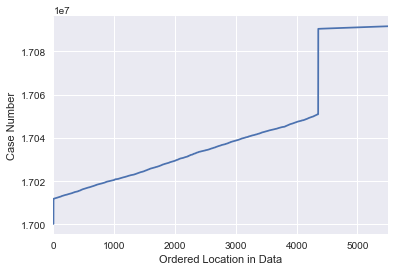

In [32]:
calls['CASENO'].sort_values().reset_index(drop=True).plot()
plt.xlabel("Ordered Location in Data")
plt.ylabel("Case Number")

I like to use interactive plotting tools so I can hover the mouse over the plot and read the values.  The cufflinks library adds plotly support to Pandas.  

In [33]:
calls['CASENO'].sort_values().reset_index(drop=True).iplot(
    xTitle="Ordered Location in Data",
    yTitle="Case Number", 
    layout = dict(yaxis=dict(hoverformat="d")))

Examining the distribution of case numbers shows a similar pattern

In [34]:
calls['CASENO'].iplot(kind="hist",bins=100)

### What might we be observing?

One possible explanation is that case numbers were assigned consecutively and then sampled uniformly at different rates for two different periods.  We will be able to understand this better by looking at the dates on the cases.

---
<br/><br/><br/>

## Examining the Date

Given the weird behavior with the case numbers let's dig into the date in which events were recorded.  Notice in this data we have several pieces of date/time information (this is not uncommon):
1. **`EVENTDT`**: This contains the date the event took place.  While it has time information the time appears to be `00:00:00`.  
1. **`EVENTTM`**: This contains the time at which the event took place.
1. **`InDbDate`**: This appears to be the date at which the data was entered in the database.  

In [35]:
calls.head(3)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday,37.876965,-122.260544
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday,37.869363,-122.268028
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday,37.865491,-122.310065


When Pandas loads more complex fields like dates it will often load them as strings:

In [36]:
calls["EVENTDT"][0]

'07/23/2017 12:00:00 AM'

We will want to convert these to dates.  Pandas has a fairly sophisticated function `pd.to_datetime` which is capable of guessing reasonable conversions of dates to date objects. 

In [37]:
dates = pd.to_datetime(calls["EVENTDT"])

We can verify that the translations worked by looking at a few dates:

In [38]:
pd.DataFrame(dict(transformed=dates, original=calls["EVENTDT"])).head()

,original,transformed
0,07/23/2017 12:00:00 AM,2017-07-23
1,04/13/2017 12:00:00 AM,2017-04-13
2,08/24/2017 12:00:00 AM,2017-08-24
3,04/06/2017 12:00:00 AM,2017-04-06
4,08/01/2017 12:00:00 AM,2017-08-01


We can also extract the time field:

In [39]:
times = pd.to_datetime(calls["EVENTTM"]).dt.time
times.head()

0    06:00:00
1    08:45:00
2    18:30:00
3    17:30:00
4    18:00:00
Name: EVENTTM, dtype: object

To combine the correct date and correct time field we use the built-in python datetime combine function.

In [40]:
from datetime import datetime
timestamps = pd.to_datetime(pd.concat([dates, times], axis=1).apply(
    lambda r: datetime.combine(r['EVENTDT'], r['EVENTTM']), axis=1))
timestamps.head()

0   2017-07-23 06:00:00
1   2017-04-13 08:45:00
2   2017-08-24 18:30:00
3   2017-04-06 17:30:00
4   2017-08-01 18:00:00
dtype: datetime64[ns]

We now updated calls to contain this additional informations:

In [41]:
calls['timestamp'] = timestamps
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday,37.876965,-122.260544,2017-07-23 06:00:00
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday,37.869363,-122.268028,2017-04-13 08:45:00
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday,37.865491,-122.310065,2017-08-24 18:30:00
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday,37.869318,-122.296984,2017-04-06 17:30:00
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday,37.854247,-122.24375,2017-08-01 18:00:00


### What time range does the data represent

In [42]:
calls['timestamp'].min()

Timestamp('2017-03-02 02:00:00')

In [43]:
calls['timestamp'].max()

Timestamp('2017-08-28 09:35:00')

---
<br/><br/><br/>

### Back to the Case Numbers

In [44]:
(
    calls
        .sort_values('timestamp')
        .iplot(
            mode='markers', size=5,
            x='timestamp', y='CASENO',
            xTitle="Ordered Location in Data",
            yTitle="Case Number", 
            layout = dict(yaxis=dict(hoverformat="d")))
)

#### Explanation?

Perhaps there are multiple different record books with different numbering schemes?  This might be something worth investigating further.

---
<br/><br/><br/>


### Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [45]:
calls['timestamp'].dt.dayofweek.value_counts().iplot(kind='bar', yTitle="Count")

In [46]:
help(pd.Series.dt.dayofweek)

Help on property:

    The day of the week with Monday=0, Sunday=6



Modified version with dates:

In [47]:
dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

(
    pd.concat([
        pd.Series(dow, name="dow"), 
        calls['timestamp'].dt.dayofweek.value_counts()], 
        axis=1)
    .set_index("dow")
    .iplot(kind="bar", yTitle="Count")
)

We can check against the day of the week field we added:

In [48]:
(
    calls['Day'].value_counts()[dow]
    .iplot(kind="bar", yTitle="Count")
)

How about temporal patterns within a day?

In [49]:
ts = calls['timestamp']
minute_of_day = ts.dt.hour * 60 + ts.dt.minute
hour_of_day = minute_of_day / 60.

calls['minute_of_day'] = minute_of_day
calls['hour_of_day'] = hour_of_day


In [50]:
py.iplot(ff.create_distplot([hour_of_day],group_labels=["Hour"],bin_size=1))

### Observations?

In the above plot we see the standard pattern of limited activity early in the morning around here 6:00AM.

---
<br/><br/><br/>

### Smoothing Parameters

In the above plot we see a smoothed curve approximating the histogram.  This is an example of a kernel density estimator (KDE).  The KDE, like the histogram, has a parameter that determines it's smoothness.  Many packages (Plotly and Seaborn) use a boostrap like procedure to choose the best value.  

To understand how this parameter works we will use seaborn which let's you also set the parameter manually.  

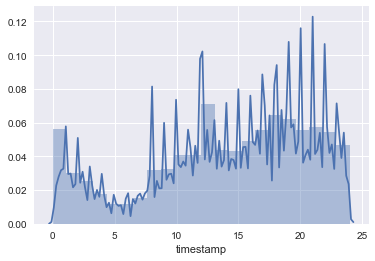

In [51]:
sns.distplot(hour_of_day, kde_kws=dict(bw=.1), rug=False)

Notice in the above plot that the interpolation tries to follow the histogram to closely. 

### Stratified Analysis

To better understand the time of day a report occurs we could stratify the analysis by the day of the week.  To do this we will use box plots.  


In [52]:
## Using Pandas built in box plot
# calls['hour_of_day'] = minute_in_day
# calls.boxplot('hour_of_day', by='Day')

In [53]:
groups = calls.groupby("CVDOW")
py.iplot([go.Box(y=df["hour_of_day"], name=str(cvdow.loc[i][0])) for (i, df) in groups])

#### Observations?

There are no very clear patterns here.  It is possible Fridays might have crimes shifted slightly more to the evening.  In general the time a crime is reported seems fairly consistent throughout the week.

In [54]:
# fig = ff.create_violin(calls, data_header='hour_of_day', group_header='Day')
# py.iplot(fig, filename='Multiple Violins')

---
<br/><br/><br/>

### Examining the Event

We also have data about the different kinds of crimes being reported

In [55]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp,minute_of_day,hour_of_day
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday,37.876965,-122.260544,2017-07-23 06:00:00,360,6.00
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday,37.869363,-122.268028,2017-04-13 08:45:00,525,8.75
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday,37.865491,-122.310065,2017-08-24 18:30:00,1110,18.50
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday,37.869318,-122.296984,2017-04-06 17:30:00,1050,17.50
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday,37.854247,-122.24375,2017-08-01 18:00:00,1080,18.00


### The Offense Field

The Offense field appears to contain the specific crime being reported.  As nominal data we might want to see a summary constructed by computing counts of each offense type:

In [56]:
calls['OFFENSE'].value_counts().iplot(kind="bar")

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

---
<br/><br/><br/>

### CVLEGEND

The CVLEGEND filed provides the broad category of crime and is a good mechanism to group potentially similar crimes. 

In [57]:
calls['CVLEGEND'].value_counts().iplot(kind="bar")

Notice that when we group by the crime time we see that **larceny** becomes the dominant category.  Larceny is essentially stealing -- taking someone else stuff without force.

### Stratified Analysis of Time of Day by CVLEGEND

View the crime time periods broken down by crime type:

In [58]:
boxes = [(len(df), go.Box(y=df["hour_of_day"], name=i)) for (i, df) in calls.groupby("CVLEGEND")]
py.iplot([r[1] for r in sorted(boxes, key=lambda x:x[0], reverse=True)])

## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

In [59]:
missing_lat_lon = calls[calls[['Lat', 'Lon']].isnull().any(axis=1)]
missing_lat_lon['CVLEGEND'].value_counts().iplot(kind="bar")

### Observations?

There is a clear bias towards drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

We might further normalize the analysis by the frequency to find which type of crime has the highest proportion of missing values.

In [60]:
(
    missing_lat_lon['CVLEGEND'].value_counts() / calls['CVLEGEND'].value_counts()
).sort_values(ascending=False).iplot(kind="bar")

---
<br/><br/><br/> 

### Day of Year and Missing Values:

We might also want to examine the time of day in which latitude and longitude are missing:

In [61]:
ts = calls['timestamp']

py.iplot(ff.create_distplot([calls['timestamp'].dt.dayofyear, 
                             missing_lat_lon['timestamp'].dt.dayofyear],
                            group_labels=["all data", "missing lat-lon"],bin_size=2))

### Observations?

Pretty similar 

In [62]:
!pip install --upgrade folium
import folium
print(folium.__version__, "should be at least 0.3.0")

Requirement already up-to-date: folium in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages
Requirement already up-to-date: requests in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from folium)
Requirement already up-to-date: jinja2 in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from folium)
Requirement already up-to-date: six in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from folium)
Requirement already up-to-date: branca in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from folium)
Requirement already up-to-date: idna<2.7,>=2.5 in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from requests->folium)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (from requests->folium)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /Users/jegonzal/anaconda3/envs/ds100/lib/python3.6/site-packages (fr

In [63]:
import folium
import folium.plugins # The Folium Javascript Map Library

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls[['Lat', 'Lon']].astype('float').dropna().as_matrix()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

In [64]:
cluster = folium.plugins.MarkerCluster()
for _, r in calls[['Lat', 'Lon', 'CVLEGEND']].dropna().sample(1000).iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Lon"])], popup=r['CVLEGEND']))
    
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
sf_map.add_child(cluster)
sf_map